# Adjusting the weights of the prior to improve performance

Here we look at some objects where the maximisation of the posterior PDF produces a poorer fit than the prior PDF values. I think the issue stems from the prior being underweighted. Let's see

This analysis is done on TESS S05_1_1 data

In [2]:
import os
import glob as g
from cotrendy.utils import depicklify
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import periodogram  
import scipy.optimize as optimization 

TIC-9113879:
Buffing prior weight 11.343 --> 1.134
Variability: 0.789
Prior goodness: 0.991
65.87476187102018
125.77036783051253


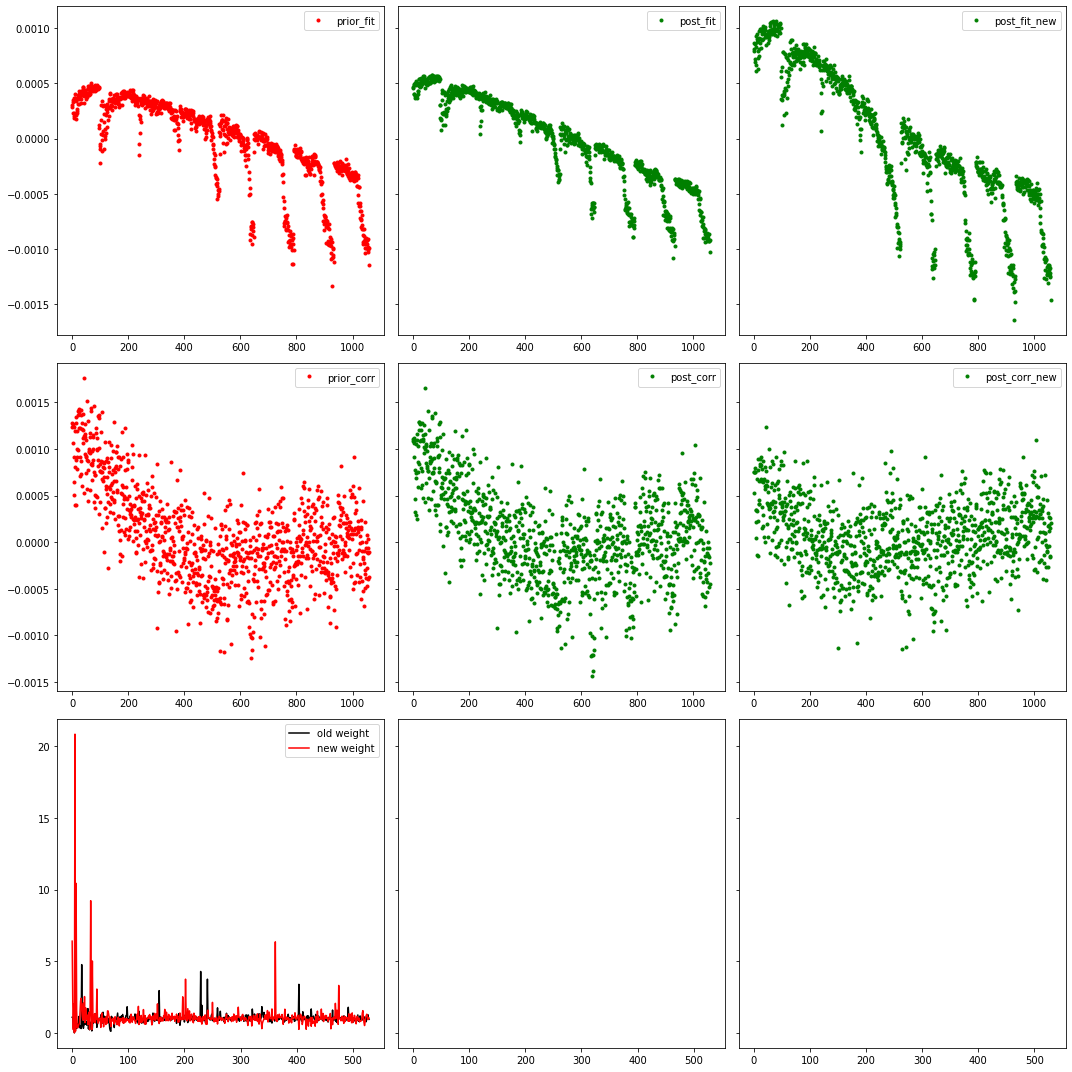

In [42]:
data_dir = "/Users/jmcc/Desktop/pngs/S05_1_1_25_15_weight"
os.chdir(data_dir)

tic_ids = [9113879]

for tic_id in tic_ids:
    mapp_file = f"TIC-{tic_id}_map.pkl"
    mapp = depicklify(mapp_file)

    cbvs_file = "tess_S05_1_1_cbvs.pkl"
    cbvs = depicklify(cbvs_file)

    tus_id = mapp.tus_id

    # work out the posterior info
    post_coeffs = []
    for cbv_id in sorted(cbvs.cbvs.keys()):
        post_coeffs.append(mapp.posterior_peak_theta[cbv_id])
    post_coeffs = np.array(post_coeffs).reshape(cbvs.n_cbvs, -1)
    post_fit = np.sum(cbvs.vect_store*post_coeffs, axis=0)
    corr_post = cbvs.norm_flux_array[tus_id] - post_fit
    
    
    # work out prior info
    prior_coeffs = []
    for cbv_id in sorted(cbvs.cbvs.keys()):
        prior_coeffs.append(mapp.prior_peak_theta[cbv_id])
    prior_coeffs = np.array(prior_coeffs).reshape(cbvs.n_cbvs, -1)
    prior_fit = np.sum(cbvs.vect_store*prior_coeffs, axis=0)
    corr_prior = cbvs.norm_flux_array[tus_id] - prior_fit

    
    # now start messing with the prior weights to see if we can find a solution to the prior weighting factor
    old_prior_weight = mapp.prior_weight
    
    new_prior_weight = old_prior_weight * 0.1
    mapp.prior_weight = new_prior_weight
    
    print(f"TIC-{tic_id}:")
    print(f"Buffing prior weight {old_prior_weight:.3f} --> {new_prior_weight:.3f}")
    print(f"Variability: {cbvs.variability[tus_id]:.3f}")
    print(f"Prior goodness: {mapp.prior_general_goodness:.3f}")
    
    # redo the posterior calculation
    mapp.calculate_posterior_pdfs(cbvs)
    
    # check the new posterior coeffs after reweighting
    post_coeffs_n = []
    for cbv_id in sorted(cbvs.cbvs.keys()):
        post_coeffs_n.append(mapp.posterior_peak_theta[cbv_id])
    post_coeffs_n = np.array(post_coeffs_n).reshape(cbvs.n_cbvs, -1)
    
    # redo the posterior fit
    post_fit_n = np.sum(cbvs.vect_store*post_coeffs_n, axis=0)
    
    # redo the correction with the newly weighted fit
    corr_post_n = cbvs.norm_flux_array[tus_id] - post_fit_n
    
    # do a noise analysis between the posterior and the prior lcs
    # the posterior should not be noisier than the prior lc, can this be used to tweak the weighting?
    _, psd_post = periodogram(np.diff(corr_post), detrend=False)
    _, psd_post_n = periodogram(np.diff(corr_post_n), detrend=False)
    _, psd_prior = periodogram(np.diff(corr_prior), detrend=False)

    psd_ratio = psd_prior / psd_post 
    sum_ratio = np.sum(np.log(psd_ratio[psd_ratio > 1]**2))
    #sum_ratio = np.sum(psd_ratio[psd_ratio > 1])
    print(sum_ratio)


    psd_ratio_n = psd_prior / psd_post_n
    sum_ratio_n = np.sum(np.log(psd_ratio_n[psd_ratio_n > 1]**2))
    #sum_ratio_n = np.sum(psd_ratio_n[psd_ratio_n > 1])
    print(sum_ratio_n)
    
    # plot everything together
    fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharex="row", sharey="row")

    _ = ax[0, 0].plot(prior_fit, 'r.', label='prior_fit')
    _ = ax[0, 1].plot(post_fit, 'g.', label='post_fit')
    _ = ax[0, 2].plot(post_fit_n, 'g.', label='post_fit_new')
    _ = ax[0, 0].legend()
    _ = ax[0, 1].legend()
    _ = ax[0, 2].legend()

    _ = ax[1, 0].plot(corr_prior, 'r.', label='prior_corr')
    _ = ax[1, 1].plot(corr_post, 'g.', label='post_corr')
    _ = ax[1, 2].plot(corr_post_n, 'g.', label='post_corr_new')
    _ = ax[1, 0].legend()
    _ = ax[1, 1].legend()
    _ = ax[1, 2].legend()
    
    _ = ax[2, 0].plot(psd_ratio, 'k-', label="old weight")
    _ = ax[2, 0].plot(psd_ratio_n, 'r-', label="new weight")
    _ = ax[2, 0].legend()

    fig.tight_layout()
    
    plt.show()

In [17]:
mapp.prior_weight

8.768507252025419

# Try some fitting to find the best weight

In [ ]:
def fit_for_weight(x, mapp_obj, cbvs_obj):
    old_prior_weight = mapp_obj.prior_weight
    
    mapp_obj.prior_weight = old_prior_weight * x[0]
        
    # redo the posterior calculation
    mapp_obj.calculate_posterior_pdfs(cbvs_obj)
    
    # check the new posterior coeffs after reweighting
    post_coeffs_n = []
    for cbv_id in sorted(cbvs_obj.cbvs.keys()):
        post_coeffs_n.append(mapp_obj.posterior_peak_theta[cbv_id])
    post_coeffs_n = np.array(post_coeffs_n).reshape(cbvs_obj.n_cbvs, -1)
    
    # redo the posterior fit
    post_fit_n = np.sum(cbvs_obj.vect_store*post_coeffs_n, axis=0)
    
    # redo the correction with the newly weighted fit
    corr_post_n = cbvs_obj.norm_flux_array[mapp_obj.tus_id] - post_fit_n
    
    # do a noise analysis between the posterior and the prior lcs
    # the posterior should not be noisier than the prior lc, can this be used to tweak the weighting?
    _, psd_post_n = periodogram(np.diff(corr_post_n), detrend=False)

    psd_ratio_n = psd_prior / psd_post_n
    sum_ratio_n = np.sum(np.log(psd_ratio_n[psd_ratio_n > 1]**2))
    return [sum_ratio_n]

In [ ]:
x0 = [1.0]
res = optimization.least_squares(fit_for_weight, x0,                     
                                 args=(mapp, cbvs),
                                 loss='soft_l1')                                 
xc = res['x']                                                                    

In [ ]:
xc[0]

# Get a histogram of all the prior goodness values


In [ ]:
mapp_files = g.glob('TIC-*_map.pkl')

In [ ]:
goodness = []
for mapp_file in mapp_files:
    mapp_a = depicklify(mapp_file)
    goodness.append(mapp_a.prior_goodness)

goodness = np.array(goodness)    
plt.hist(goodness, bins=50, log=True)

In [ ]:
n = np.where(goodness < 0.01)[0]

In [ ]:
np.array(mapp_files)[n]

In [9]:
help(fig)

Help on Figure in module matplotlib.figure object:

class Figure(matplotlib.artist.Artist)
 |  Figure(figsize=None, dpi=None, facecolor=None, edgecolor=None, linewidth=0.0, frameon=None, subplotpars=None, tight_layout=None, constrained_layout=None)
 |  
 |  The top level container for all the plot elements.
 |  
 |  The Figure instance supports callbacks through a *callbacks* attribute
 |  which is a `.CallbackRegistry` instance.  The events you can connect to
 |  are 'dpi_changed', and the callback will be called with ``func(fig)`` where
 |  fig is the `Figure` instance.
 |  
 |  Attributes
 |  ----------
 |  patch
 |      The `.Rectangle` instance representing the figure background patch.
 |  
 |  suppressComposite
 |      For multiple figure images, the figure will make composite images
 |      depending on the renderer option_image_nocomposite function.  If
 |      *suppressComposite* is a boolean, this will override the renderer.
 |  
 |  Method resolution order:
 |      Figure
 |